Test integration of GNATSS kalman filter for position interpolation

In [1]:
from es_sfgtools.tiledb_tools.tiledb_schemas import TDBKinPositionArray, TDBShotDataArray, TDBIMUPositionArray
from es_sfgtools.utils.archive_pull import load_site_metadata
from es_sfgtools.modeling.garpos_tools.functions import CoordTransformer
from datetime import datetime, timedelta
import pandas as pd     
import matplotlib.pyplot as plt


/Users/gottlieb/opt/anaconda3/envs/seafloor_geodesy_mac/lib/python3.11/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'validate_by_name'
  warnings.warn(message, UserWarning)


# Set up test case
Kin data is stored in TDBKinPositionArray
dfop00 data is stored in TDBShotDataArray
imu data is stored in TDBIMUPositionArray

updated data generated using interpolate_enu_radius_regression

In [2]:
tdb_dir = "/Users/gottlieb/data/sfg/cascadia-gorda/NCC1/TileDB/"
kin_data = TDBKinPositionArray(tdb_dir + "kin_position.tdb")
dfo_data = TDBShotDataArray(tdb_dir + "shotdata_pre.tdb")
imu_data = TDBIMUPositionArray(tdb_dir + "imu_position.tdb")

site = load_site_metadata(network='cascadia-gorda', station='NCC1')
ct = CoordTransformer(site.arrayCenter.latitude, site.arrayCenter.longitude, site.arrayCenter.elevation)

Loading site metadata from https://data.earthscope.org/archive/seafloor/metadata/cascadia-gorda/NCC1.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1063.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1065.json


In [3]:
year = 2024
start = datetime(year, 9, 23)
end = datetime(year, 9, 23)
dfo_df = dfo_data.read_df(start=start)

dfo_df['returnDT'] = pd.to_datetime(dfo_df['returnTime'], unit='s')
dfo_df.set_index('returnDT', inplace=True)
dfo_df.sort_index(inplace=True)
#transform into ENU coordinates
dfo_df['east1_m'], dfo_df['north1_m'], dfo_df['up1_m'] = ct.ECEF2ENU_vec(dfo_df['east1'], dfo_df['north1'], dfo_df['up1'])
dfo_df

,pingTime,transponderID,head0,pitch0,roll0,head1,pitch1,roll1,east0,north0,...,returnTime,tt,dbv,xc,snr,tat,isUpdated,east1_m,north1_m,up1_m
returnDT,,,,,,,,,,,,,,,,,,,,,
2024-09-23 00:00:07.492181063,1.727050e+09,IR5209,253.472588,-2.753416,-1.978644,259.965767,0.584148,2.057784,-2.732552e+06,-3.912715e+06,...,1.727050e+09,1.292181,0,90,38.0,0.2,0,768.077470,-77.219599,-3.131648
2024-09-23 00:00:22.490181923,1.727050e+09,IR5209,257.566879,4.228953,-9.825532,269.217369,1.112906,-10.693155,-2.732559e+06,-3.912714e+06,...,1.727050e+09,1.290182,0,80,36.0,0.2,0,761.875232,-81.034250,-4.646952
2024-09-23 00:00:37.490663052,1.727050e+09,IR5209,261.700012,1.489000,-5.722022,257.046822,6.796095,0.478458,-2.732564e+06,-3.912711e+06,...,1.727050e+09,1.290663,0,87,34.0,0.2,0,754.871440,-83.928278,-3.267158
2024-09-23 00:00:52.490828037,1.727050e+09,IR5209,268.273766,-3.833319,-5.317166,255.750191,0.672265,-3.856687,-2.732570e+06,-3.912709e+06,...,1.727050e+09,1.290828,0,88,37.0,0.2,0,749.445380,-87.413017,-1.260566
2024-09-23 00:01:07.489980936,1.727050e+09,IR5209,249.832527,4.506808,-9.647501,248.096321,0.639276,2.948189,-2.732578e+06,-3.912709e+06,...,1.727050e+09,1.289981,0,49,36.0,0.2,0,743.483932,-94.728679,-0.883974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23 23:58:49.910829067,1.727136e+09,IR5209,327.652992,3.930960,2.570795,332.497328,8.326149,-1.063659,-2.733088e+06,-3.912091e+06,...,1.727136e+09,1.710829,-14,78,22.0,0.2,0,-27.997760,231.091504,-1.079257
2024-09-23 23:59:04.915359974,1.727136e+09,IR5209,347.953854,4.303762,5.636971,356.487666,1.940790,-3.864130,-2.733088e+06,-3.912087e+06,...,1.727136e+09,1.715360,-9,76,15.0,0.2,0,-31.100079,236.494069,-2.159470
2024-09-23 23:59:19.916836977,1.727136e+09,IR5209,31.131521,-4.431863,-1.309550,32.642342,5.021528,-1.636214,-2.733085e+06,-3.912084e+06,...,1.727136e+09,1.716837,-8,51,34.0,0.2,0,-28.488877,243.080288,-1.967706


In [4]:
kin_df = kin_data.read_df(start=start, end=end)
# transform into ENU coordinates
kin_df['east_m'], kin_df['north_m'], kin_df['up_m'] = ct.ECEF2ENU_vec(kin_df['east'], kin_df['north'], kin_df['up'])
kin_df

,time,latitude,longitude,height,east,north,up,number_of_satellites,pdop,wrms,east_m,north_m,up_m
0,2024-09-23 00:00:00.500,41.656274,235.070447,-29.8143,-2.732549e+06,-3.912714e+06,4.217136e+06,11,1.29,3.382666,770.753409,-74.190522,-2.431248
1,2024-09-23 00:00:02.500,41.656280,235.070439,-28.5357,-2.732550e+06,-3.912714e+06,4.217137e+06,11,1.29,4.393902,770.067346,-73.544974,-1.152587
2,2024-09-23 00:00:10.500,41.656261,235.070411,-27.7445,-2.732553e+06,-3.912715e+06,4.217136e+06,11,1.29,3.867669,767.783051,-75.715259,-0.361062
3,2024-09-23 00:00:44.500,41.656191,235.070220,-29.9213,-2.732568e+06,-3.912709e+06,4.217129e+06,11,1.27,4.504102,751.901247,-83.420703,-2.536085
4,2024-09-23 00:01:11.499,41.656097,235.070093,-27.9606,-2.732581e+06,-3.912709e+06,4.217123e+06,12,1.20,6.979133,741.301662,-93.926030,-0.574315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10021,2024-09-23 23:59:11.500,41.659093,235.060822,-28.5206,-2.733087e+06,-3.912086e+06,4.217371e+06,12,1.20,5.517268,-30.909119,238.763647,-1.095118
10022,2024-09-23 23:59:20.499,41.659128,235.060843,-28.0056,-2.733085e+06,-3.912085e+06,4.217374e+06,12,1.20,7.478697,-29.220273,242.672543,-0.580252
10023,2024-09-23 23:59:25.500,41.659128,235.060882,-27.6433,-2.733082e+06,-3.912087e+06,4.217374e+06,12,1.20,5.890965,-25.945406,242.698791,-0.217983
10024,2024-09-23 23:59:27.499,41.659136,235.060896,-28.9727,-2.733080e+06,-3.912086e+06,4.217374e+06,12,1.20,4.895293,-24.808218,243.637833,-1.547357


In [5]:
imu_df = imu_data.read_df(start=start, end=end)
imu_df['east'], imu_df['north'], imu_df['up'] = ct.LLH2ENU_vec(imu_df['latitude'], imu_df['longitude'], imu_df['height'])
imu_df


,time,azimuth,pitch,roll,latitude,longitude,height,latitude_std,longitude_std,height_std,...,upVelocity,northVelocity_std,eastVelocity_std,upVelocity_std,roll_std,pitch_std,azimuth_std,east,north,up
0,2024-09-23 00:00:00.000,275.087434,5.395865,11.930903,41.656267,-124.929549,-29.5389,NaN,NaN,NaN,...,-1.5025,NaN,NaN,NaN,NaN,NaN,NaN,771.081313,-75.041100,-2.155883
1,2024-09-23 00:00:00.050,274.861804,5.630769,10.657970,41.656267,-124.929550,-29.6522,NaN,NaN,NaN,...,-1.8283,NaN,NaN,NaN,NaN,NaN,NaN,771.044392,-75.034028,-2.269179
2,2024-09-23 00:00:00.100,274.632913,5.739947,8.856843,41.656267,-124.929550,-29.8254,NaN,NaN,NaN,...,-2.1552,NaN,NaN,NaN,NaN,NaN,NaN,771.009376,-75.032072,-2.442375
3,2024-09-23 00:00:00.150,274.392305,5.740517,6.659957,41.656267,-124.929551,-30.0014,NaN,NaN,NaN,...,-2.3711,NaN,NaN,NaN,NaN,NaN,NaN,770.974330,-75.029408,-2.618370
4,2024-09-23 00:00:00.200,274.139606,5.631287,4.205768,41.656267,-124.929551,-30.1843,NaN,NaN,NaN,...,-2.5034,NaN,NaN,NaN,NaN,NaN,NaN,770.940585,-75.023716,-2.801266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493449,2024-09-23 23:59:59.800,95.424120,-6.990507,5.580464,41.659034,-124.938903,-26.9838,NaN,NaN,NaN,...,-0.0789,NaN,NaN,NaN,NaN,NaN,NaN,-8.027827,232.230630,0.441958
1493450,2024-09-23 23:59:59.850,94.592342,-6.187441,5.248328,41.659033,-124.938903,-26.9787,NaN,NaN,NaN,...,-0.0401,NaN,NaN,NaN,NaN,NaN,NaN,-8.001852,232.167239,0.447060
1493451,2024-09-23 23:59:59.900,93.800590,-5.215966,5.002010,41.659033,-124.938902,-26.9723,NaN,NaN,NaN,...,-0.0191,NaN,NaN,NaN,NaN,NaN,NaN,-7.974845,232.100756,0.453462
1493452,2024-09-23 23:59:59.950,93.058894,-4.121225,4.848205,41.659032,-124.938902,-26.9645,NaN,NaN,NaN,...,0.0092,NaN,NaN,NaN,NaN,NaN,NaN,-7.946386,232.031221,0.461265


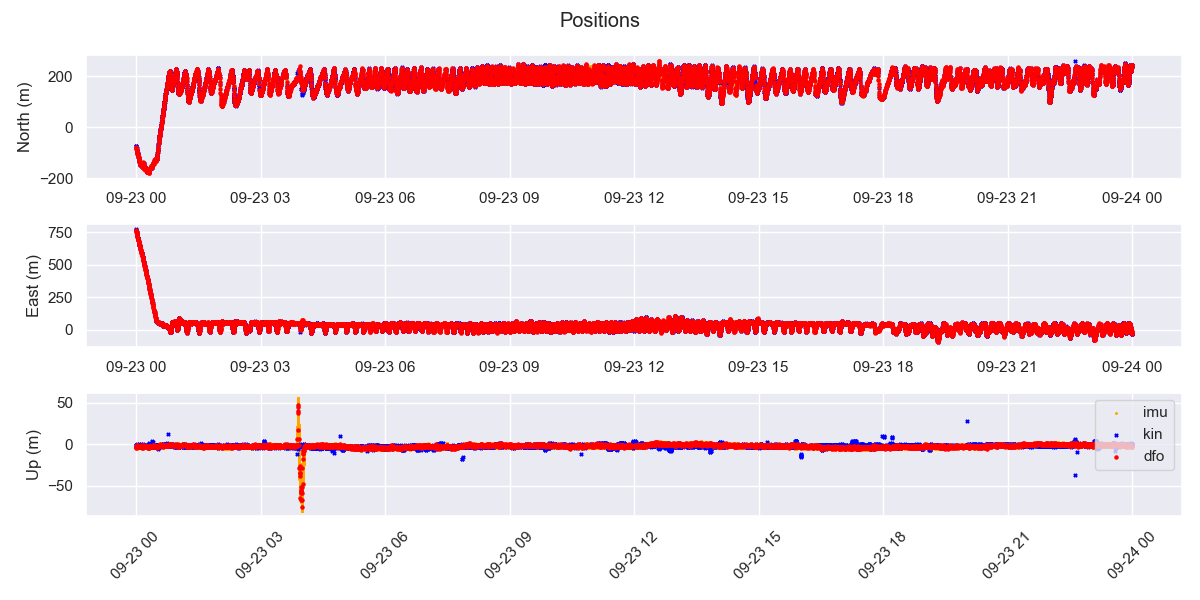

In [6]:
%matplotlib ipympl

s=5
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
axs[0].scatter(imu_df['time'], imu_df['north'], label='imu', color='orange', s=s, marker=".")
axs[0].scatter(kin_df['time'], kin_df['north_m'], label='kin', color='blue', marker='x',s=s)
axs[0].scatter(dfo_df.index, dfo_df['north1_m'], label='dfo', color='red', s=s)
#axs[0].scatter(shotdata_df_updated.index, shotdata_df_updated['north1'], label='updated', color='green', s=s, marker="+")
axs[0].set_ylabel('North (m)')
axs[1].scatter(imu_df['time'], imu_df['east'], label='imu', color='orange', s=s, marker=".")
axs[1].scatter(kin_df['time'], kin_df['east_m'], label='kin', color='blue', s=s, marker='x')
axs[1].scatter(dfo_df.index, dfo_df['east1_m'], label='dfo', color='red', s=s)
#axs[1].scatter(shotdata_df_updated.index, shotdata_df_updated['east1'], label='updated', color='green', s=s, marker="+")
axs[1].set_ylabel('East (m)')
axs[2].scatter(imu_df['time'], imu_df['up'], label='imu', color='orange', s=s, marker=".")
axs[2].scatter(kin_df['time'], kin_df['up_m'], label='kin', color='blue', s=s, marker='x')
axs[2].scatter(dfo_df.index, dfo_df['up1_m'], label='dfo', color='red', s=s)
#axs[2].scatter(shotdata_df_updated.index, shotdata_df_updated['up1'], label='updated', color='green', s=s, marker="+")
axs[2].set_ylabel('Up (m)')

fig.suptitle('Positions')
#ax.set_xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()
